Система передаёт данные по гидравлическому каналу связи, сигнал принимается датчиком давления . При обработке классическим методом (поиском экстремума) при значительной амплитуде шумов сигналапроисходит ложное определение сигнала.
Определение сигнала нейронной сетью может поночь избежать данной проблемы.

 Есть запись сигнала в текстовом файле. Данного формата. [!DTR:032.00:+01175+01162+01159+01149+01183+01120+01139+01066+01044+01047+01059+01076+01119+01102+01066+01061+01067+01048+01047+01050+01062+01017+01020+01001+01060] [!DTR:032.00:+01078+01048+01078+01087+01082+01116+01078+01095+01111+01097+01145+01203+01219+01241+01238+01232+01311+01326+01374+01373+01332+01335+01352+01414+01494] [!DTR:032.00:+01523+01526+01589+01662+01711+01700+01682+01668+01767+01818+01817+01865+01890+01934+01966+01953+02064+01973+02020+01989+01938+01951+02004+02001+02014]

In [3]:
!pip install -U -q PyDrive

Открываем доступ к файлам на облачном хранилище


In [44]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


downloaded = drive.CreateFile({'id':'1Oc47fVYOraoz0VCZ0zdspqNA-Oxm_JAL'}) 
downloaded.GetContentFile('signal_14_41_45.csv') 
downloaded1 = drive.CreateFile({'id':'11IetFg0VlKOoy3mw6ow7wdhtQss0NB1g'}) 
downloaded1.GetContentFile('signal_20_47_29.txt') 
downloaded2 = drive.CreateFile({'id':'1MfPvEwa5T3sjr-lWUTYesAdlY72JPAy3'})
downloaded2.GetContentFile('signal_20_47_29_df.csv') 
downloaded3 = drive.CreateFile({'id':'1eFEXV_QB3TEaXDIAGVylo5OPPc29REFT'})
downloaded3.GetContentFile('signal_19_23_13.txt') 
downloaded4 = drive.CreateFile({'id':'1OaSU0EojZXCNSn5L-Y2-Mj8WHaYEBeL6'})
downloaded4.GetContentFile('signal_19_23_13_df.csv')


Импортируем библиотеки

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft

from scipy.signal import argrelextrema
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot


import seaborn as sns


Пример сагнала с датчика давления

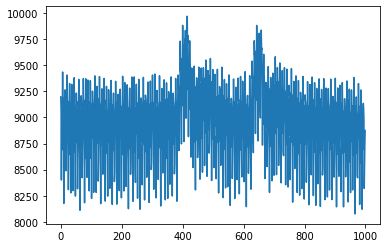

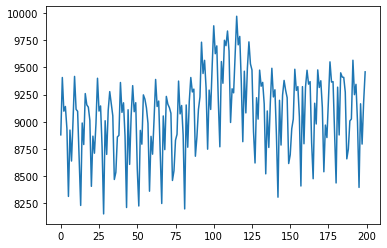

In [6]:
def to_list(df):

    listDF =[]
    for i in df:
        listDF = np.append(listDF, i)
    return  listDF

link = 'signal_14_41_45.csv'
dt = pd.read_csv(link, delimiter='+', header=None, escapechar= ']' )

dt = dt.drop(columns= 0)
df = np.array(dt)
df_list = to_list(df)
#df_list = df_list / max(df_list)

plt.plot(df_list[5000:6000])
plt.show()

plt.plot(df_list[5300:5500])
plt.show()

Сигнал к датчику приходит с шумами от насоса и работы забойного оборудования.
Для стабильной обработки сигнала нейронной сетью отчистим сигнал  от шумов используя разложение по ряду Фурье и  усреднеение для сглаживания сигнала

Дополнительные функции 

In [7]:
def to_list(df):
    '''Преобразованрие массива в список для применения фильтров'''
    listDF =[]
    for i in df:
        listDF = np.append(listDF, i)
    return  listDF


def findpeaks(x):
    '''Нахождение экстремумов максимума'''
    peaks, _ = find_peaks(x, height=0.543)
    return peaks

def set_class(df):
    '''Предопределение класса'''
    classes = []
    for i in range(len(df)):
        lis = np.array(df.take([i]))[0]
        #print(findpeaks(lis[2:]))
        if len(findpeaks(lis[2:])) != 0:
            classes.append(1)
        else:classes.append(0)
    return classes

def test_clf(file_name):
    '''
    проверка на зашумленных данных
    :param file_name:
    :return:
    '''
    df_signal = pd.read_csv('signal\df_list_n.csv')
    X = df_signal.iloc[:, 3:]
    y = df_signal.iloc[:, 2]

    y_pred = clf.predict(X)

    '''Посмотрим метрики качества модели, полученные на тестовом наборе данных при помощи 
    classification_report() из библиотеки sklearn.'''
    print(classification_report(y, y_pred, digits=3))


    probs_1 = clf.predict_proba(X)[:,1]
    print(roc_auc_score(y, probs_1))
    print(sklearn.metrics.f1_score(y, y_pred, average='macro'))

    metrics.plot_roc_curve(clf, X, y, color='darkorange')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()





Фенкция усреднения 

In [8]:
def meaning(data,  rang = 35):
    '''Усредняющий фильтр'''
    data1 = np.copy(data)
    for i in range(rang, len(data)-rang):
        data1[i] = sum(data[i-rang:i+rang])/(rang*2)
    #print('data_rang',data1[:3])
    return data1

Функция фильтрации по ряду Фурье с подобранными для данной частоты параметрами

In [9]:
def filter_FFT(data, border = 100):         #Настроить подбор параметров по частоте
    '''Полосовой филтр по ряду Фурье'''
    SAMPLE_RATE = 7.5 
    data = data/ max(data)
    yf = rfft(data)
    xf = rfftfreq(len(data), 1 / SAMPLE_RATE)

    
    points_per_freq = len(xf) / (SAMPLE_RATE / 2)

    # целевая частота
    target_idx = int(points_per_freq * 1/SAMPLE_RATE)
    #Обнулим yf для индексов около целевой частоты(заглушим ненужные частоты):

    yf[target_idx + border:] = 0
    yf[:100] = 0
    new_sig = irfft(yf)
    return new_sig

Функция присваивает класс, если вероятность отнесениия к классу больше указанного значения

In [10]:
def set_calass_y_pred(y_pred, trust_level = 0.82):
    '''
    функция классификации в соответствии с уровнем доверия
    :param trust_level: порог достоверности
    :return:  0 если не сигнал, 1 если сигнал
    '''
    for i in range(len(y_pred)):
        if y_pred[i] >= trust_level:
            y_pred[i] =  1
        else: y_pred[i] = 0
    return y_pred

Функция разделят файл сигнала на интервалы для поиска импульса
window - размер интервала
part - шаг смещения окна(нахлест) 

In [11]:

def list_to_dataFrame(data, window = 180, part = 2):
    ''' преобразование линейного массива в массив с данными размера окна
    (количества входных параметров) и предопределение класса нулём'''
    data1 = []
    for i in range(len(data)):
        data1.append([i, data[i]])              #преобразовать в удобный формат
    data2 = []
    for i in range(0, len(data) - window + 1, int(window/part)):        #проверить  последнюю запись
        if i + window <= len(data):
            data2.append(np.append([i,0], data[i:i+window]))
        else:
            data2.append(np.append(data[i:], 0))
    return data2

Преобразование текстового формата сигнала в формат для нейронной сети(0-начальная позиция в массиве первоночальных данных, 1- отнесение к классу(есть сигнал в этом массиве или нет), последующие - набор параметров сигнала).

Считываем и удаляем лишние символы.

Преобразуем массив в строку для примнения фильтров.

Применяем фильтра- усредняющий и частотный.

Нормируем данные.

После создаем объект дата фрейма с настроеным перехлестом и шириной окна поиска сигнала.

Определяем наличие сигнала классическим методом поиска сигнала (нахождение экстремума).




In [12]:
def bild_DF(file_name_to_read = 'signal_19_23_13.txt', file_name_to_write = 'signal_19_23_13_df.csv'):
    '''
    Преобразование файла данных в файл с размером окна в соответствии с шириной импульса, отчистка от шума и
    нормализация данных
    :param file_name_to_read:  файл данных
    :param file_name_to_write: готовый файл для нейронной сети
    :return:
    '''

    dt = pd.read_csv(file_name_to_read, delimiter='+', header=None, escapechar= ']' )

    dt = dt.drop(columns= 0)
    df = np.array(dt)

    df_list = to_list(df)
    print('весь сигнал до обработки')
    plt.plot(df_list)
    plt.show()
    print('участок с сигналом до обработки')
    plt.plot(df_list[40000:40500])
    plt.show()
    #df_list_n = df_list.copy()

    #df_list_n = (df_list_n - df_list_n.min())/(df_list_n.max() - df_list_n.min())
    #df_list_n = pd.DataFrame(list_to_dataFrame(df_list_n))
    #df_list_n[1] = set_class(df_list_n)

    #plt.plot(df_list_n)
    #plt.show()
    df_list = meaning(df_list)
    print('участок с сигналом после усреднения')
    plt.plot(df_list[40000:40500])
    plt.show()
    df_list = filter_FFT(df_list)
    print('участок с сигналом после частотного фильтра')
    plt.plot(df_list[40000:40500])
    plt.show()
    df_list_normed = (df_list - df_list.min())/(df_list.max() - df_list.min())
    print('участок с сигналом после нормализации')
    plt.plot(df_list_normed[40000:40500])
    plt.show()


    df = pd.DataFrame(list_to_dataFrame(df_list_normed)) #создание датафрейма для сети

    df[1] = set_class(df)
   # print(df.get(df[1]==1))
    df.to_csv(file_name_to_write)
    #df_list_n.to_csv('signal\df_list_n.csv')


Построим модель на основе библиотеки sklearn используя MLPClassifier и оценим её


In [13]:
def lerningsis():

    '''
    обучение сети на основе библиотеки sklearn и оценка параметров

    :return:
    '''

    warnings.filterwarnings('ignore')
    df_signal = pd.read_csv('signal_19_23_13_df.csv')

    X = df_signal.iloc[:,3:]
    y = df_signal.iloc[:,2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)


    '''Построим и обучим классификатор на основе MLPClassifier из библиотеки sklearn'''

    clf = MLPClassifier(random_state=19, max_iter=100, hidden_layer_sizes=(180,  128, 64,32, 16, 8, 4,2,))
    #print(y_train, y_test)
    clf.fit(X_train, y_train)

    '''Выполним предсказания для тестового набора данных'''

    y_pred = clf.predict(X_test)
    #print('clf.predict_proba(X_test)', y_pred)


    '''Посмотрим метрики качества модели, полученные на тестовом наборе данных при помощи 
    classification_report() из библиотеки sklearn.'''
    print(classification_report(y_test, y_pred, digits=3))


    probs_1 = clf.predict_proba(X_test)[:,1]
    print(roc_auc_score(y_test, probs_1))
    print(sklearn.metrics.f1_score(y_test, y_pred, average='macro'))

    metrics.plot_roc_curve(clf, X_test, y_test, color='darkorange')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    return clf

Обучение сети tensorflow.keras.sequentia и оценка качества модели

In [22]:

def sequentia_model(ep = 30):
    
    df_signal = pd.read_csv('signal_20_47_29_df.csv')
    #print(df_signal)
    X = df_signal.iloc[:, 3:]
    y = df_signal.iloc[:, 2]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,  random_state=19)

    test_file = pd.read_csv('signal_19_23_13_df.csv')
    #print(test_file)
    X_test = test_file.iloc[:, 3:]
    y_test = test_file.iloc[:, 2]

  

    #plt.plot(X_t_n.iloc[2:12, :])
    # plt.show()

    model = Sequential()
    model.add(Dense(64, input_dim=180, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(256, activation='softmax'))
    #model.add(Dropout(0.5))
    model.add(Dense(32, activation='softmax'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

  
    # Задача бинарной классификации
    model.compile(optimizer=Adam(learning_rate=0.001),  loss='MSE', metrics=['binary_accuracy']) #используем оптимизатор Adam, функция потерь - среднеквадратичная ошибка, 
    
    history = model.fit(X_train, y_train, epochs=ep, batch_size=16, validation_data=[X_val,y_val])

    score = model.evaluate(X_test, y_test, batch_size=8)
    print('score', score)
    y_pred = model.predict(X_test,batch_size=8)
    y_pred = set_calass_y_pred(y_pred, 0.95) # настроить достоверность (порог) данных 0,85

    #print(classification_report(y_test, y_pred, digits=3))




    df = pd.DataFrame(history.history)
    print(df)
    plt.plot(df)
    plt.xlim([-0.01, ep])
    plt.ylim([0.0, 01.01])
    plt.xlabel('Epochs')
    plt.ylabel(' ')
    plt.title('')
    plt.legend(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
    #plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    #plt.title()
    #plt.show()

    display(plot_model(model, show_shapes=True))

    #display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
   

In [71]:

def sequentia_model_2(ep = 30):
    
    df_signal = pd.read_csv('signal_20_47_29_df.csv')
    #print(df_signal)
    X = df_signal.iloc[:, 3:]
    y = df_signal.iloc[:, 2]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,  random_state=19)

    test_file = pd.read_csv('signal_19_23_13_df.csv')
    #print(test_file)
    X_test = test_file.iloc[:, 3:]
    y_test = test_file.iloc[:, 2]

  

    #plt.plot(X_t_n.iloc[2:12, :])
    # plt.show()

    model = Sequential()
    model.add(Dense(180, input_dim=180, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(124, activation='hard_sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='hard_sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='hard_sigmoid'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

  
    # Задача бинарной классификации
    model.compile(optimizer=Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  loss='MSE', metrics=['binary_accuracy']) #используем оптимизатор Adam, функция потерь - среднеквадратичная ошибка, 
    '''Модели Keras обучаются на Numpy-массивах, содержащих набор исходных данных и метки. 
    Для обучения обычно используется функция fit().'''
    history = model.fit(X_train, y_train, epochs=ep, batch_size=16, validation_data=[X_val,y_val])

    score = model.evaluate(X_test, y_test, batch_size=8)
    print('score', score)
    y_pred = model.predict(X_test,batch_size=8)
    y_pred = set_calass_y_pred(y_pred, 0.75) # настроить достоверность (порог) данных 0,85

    print(classification_report(y_test, y_pred, digits=3))




    df = pd.DataFrame(history.history)
    #print(df)
    plt.plot(df)
    plt.xlim([-0.01, ep])
    plt.ylim([0.0, 01.01])
    plt.xlabel('Epochs')
    plt.ylabel(' ')
    plt.title('')
    plt.legend(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
    #plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    #plt.title()
    #plt.show()
    display(plot_model(model, show_shapes=True))

    #display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
   

Тело

Обучение сети tensorflow.keras.sequentia и оценка качества модели
Epoch 1/18
180/180 [==============================] - 1s 4ms/step - loss: 0.2380 - binary_accuracy: 0.6179 - val_loss: 0.2216 - val_binary_accuracy: 0.8783
Epoch 2/18
180/180 [==============================] - 1s 3ms/step - loss: 0.2177 - binary_accuracy: 0.6721 - val_loss: 0.1947 - val_binary_accuracy: 0.8524
Epoch 3/18
180/180 [==============================] - 1s 3ms/step - loss: 0.1964 - binary_accuracy: 0.7107 - val_loss: 0.1702 - val_binary_accuracy: 0.8946
Epoch 4/18
180/180 [==============================] - 1s 3ms/step - loss: 0.1765 - binary_accuracy: 0.7260 - val_loss: 0.1449 - val_binary_accuracy: 0.9286
Epoch 5/18
180/180 [==============================] - 1s 3ms/step - loss: 0.1645 - binary_accuracy: 0.7166 - val_loss: 0.1247 - val_binary_accuracy: 0.9448
Epoch 6/18
180/180 [==============================] - 1s 3ms/step - loss: 0.1484 - binary_accuracy: 0.7434 - val_loss: 0.1111 - val_binary_accuracy: 0.946

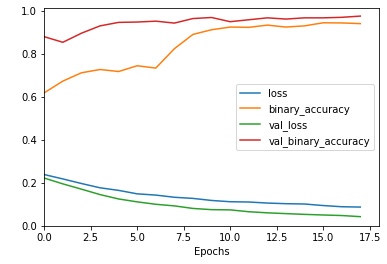

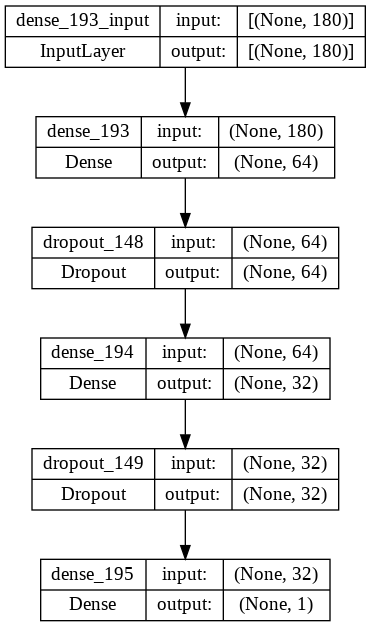

Epoch 1/20
180/180 [==============================] - 2s 5ms/step - loss: 0.2610 - binary_accuracy: 0.5407 - val_loss: 0.2373 - val_binary_accuracy: 0.5588
Epoch 2/20
180/180 [==============================] - 1s 4ms/step - loss: 0.2554 - binary_accuracy: 0.5334 - val_loss: 0.2278 - val_binary_accuracy: 0.5588
Epoch 3/20
180/180 [==============================] - 1s 4ms/step - loss: 0.2386 - binary_accuracy: 0.5789 - val_loss: 0.2068 - val_binary_accuracy: 0.8135
Epoch 4/20
180/180 [==============================] - 1s 4ms/step - loss: 0.2175 - binary_accuracy: 0.6645 - val_loss: 0.1720 - val_binary_accuracy: 0.8702
Epoch 5/20
180/180 [==============================] - 1s 3ms/step - loss: 0.1853 - binary_accuracy: 0.7497 - val_loss: 0.1332 - val_binary_accuracy: 0.8710
Epoch 6/20
180/180 [==============================] - 1s 3ms/step - loss: 0.1496 - binary_accuracy: 0.8248 - val_loss: 0.0979 - val_binary_accuracy: 0.8986
Epoch 7/20
180/180 [==============================] - 1s 4ms/ste

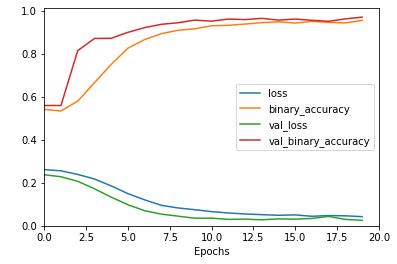

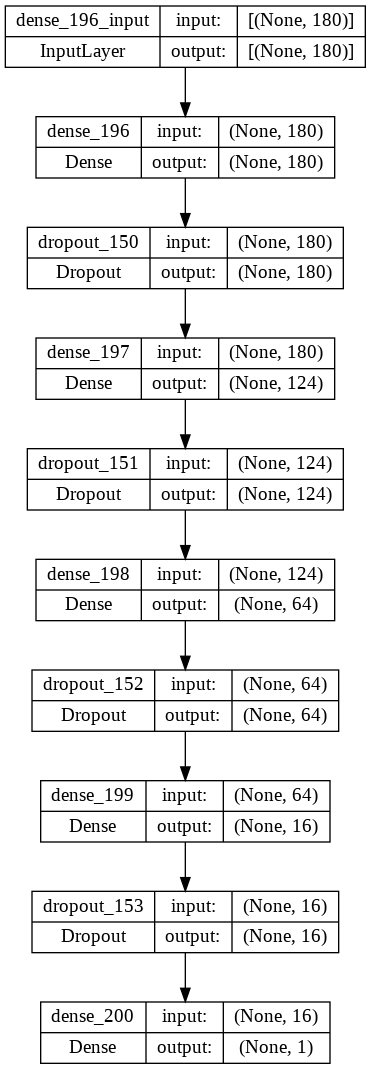

Epoch 1/14
180/180 [==============================] - 2s 5ms/step - loss: 0.2669 - binary_accuracy: 0.5122 - val_loss: 0.2396 - val_binary_accuracy: 0.5588
Epoch 2/14
180/180 [==============================] - 1s 4ms/step - loss: 0.2499 - binary_accuracy: 0.5483 - val_loss: 0.2301 - val_binary_accuracy: 0.5637
Epoch 3/14
180/180 [==============================] - 1s 4ms/step - loss: 0.2398 - binary_accuracy: 0.5807 - val_loss: 0.2108 - val_binary_accuracy: 0.8200
Epoch 4/14
180/180 [==============================] - 1s 3ms/step - loss: 0.2164 - binary_accuracy: 0.6679 - val_loss: 0.1784 - val_binary_accuracy: 0.8670
Epoch 5/14
180/180 [==============================] - 1s 4ms/step - loss: 0.1824 - binary_accuracy: 0.7646 - val_loss: 0.1340 - val_binary_accuracy: 0.8856
Epoch 6/14
180/180 [==============================] - 1s 4ms/step - loss: 0.1466 - binary_accuracy: 0.8328 - val_loss: 0.0956 - val_binary_accuracy: 0.8978
Epoch 7/14
180/180 [==============================] - 1s 4ms/ste

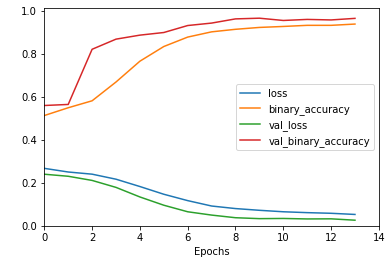

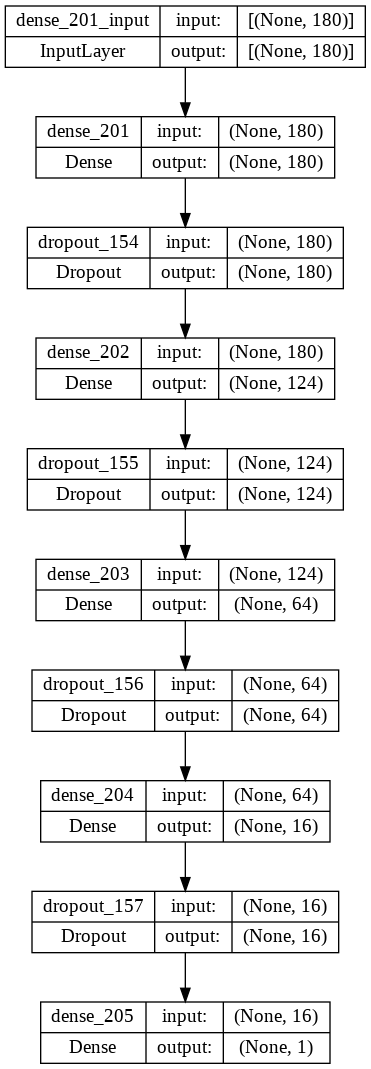

Построим модель на основе библиотеки sklearn используя MLPClassifier и оценим её
              precision    recall  f1-score   support

           0      0.995     0.986     0.991       222
           1      0.986     0.995     0.991       211

    accuracy                          0.991       433
   macro avg      0.991     0.991     0.991       433
weighted avg      0.991     0.991     0.991       433

0.9989752785961317
0.9907581319900965


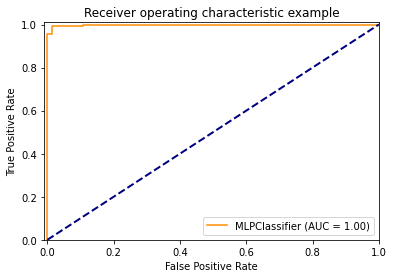

MLPClassifier(hidden_layer_sizes=(180, 128, 64, 32, 16, 8, 4, 2), max_iter=100,
              random_state=19)

In [79]:
#bild_DF()       #Преобразование файла в дата-фрейм и запись его в файл
#bild_DF(file_name_to_read = 'signal_20_47_29.txt', file_name_to_write = 'signal_20_47_29_df.csv')
print ('Обучение сети tensorflow.keras.sequentia и оценка качества модели \n Протестируем различные модели \n Первая модель')
sequentia_model(18)
print('Второй вариант :')
sequentia_model_2(20)
print('Третий вариант :')
sequentia_model_2(14)
print('Данный вариант оптимален как по качеству обученности , таак и по скорости обработки')
print('Построим модель на основе библиотеки sklearn используя MLPClassifier и оценим её')
lerningsis()
priint('Сеть на этом классификаторе полностью удволетворяет поставленной задаче, как по точности , так и по скорости работы')
#clf = lerningsis()
#test_clf('signal\df_list_n.csv')


Дальнейшее применение классификатора целесообразно  для отфильтровывания ложного сигнала , что снимет нагрузку с алгоритма декодирования и повысит качество данных.

